# Playing Atari games with DQN agent

In this tutorial we will show how to create a Reinforcement Learning agent and teach it to play a number of [Atari](https://gym.openai.com/envs/#atari) games.

![Atari](../assets/AtariGames.png)

- [Breakout](#Breakout)
- [Pong](#Pong)
- [Space Invaders](#Space-Invaders)

In [1]:
import sys
sys.path.insert(0, '..')

from collections import deque

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import gym

from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import img_as_ubyte

import matplotlib.pyplot as plt
%matplotlib inline

from pyreinforce.brain import Brain
from pyreinforce.acting import DecayingEpsGreedyPolicy
from pyreinforce.memory import EpisodicMemory
from pyreinforce.converter import Converter
from pyreinforce import TdAgent

## The Big Picture

![The Big Picture](../assets/AtariTheBigPicture.svg)

### Converter

- Converts raw RGB images to gray-scale and down-samples them
- Clips and adjusts rewards
- Treats lost life as end of episode

Atari environment returns frames in a form of 210x160 RGB images. Before feeding them into the neural network we will apply a preprocessing step in order to reduce the input dimentionality. Raw frames are cropped to roughly capture the 176x160 playing area. This output is then converted to gray-scale and resized to a 84x84 image.

It was found that clipping the rewards between -1 and 1 makes training more stable and results in faster convergence.

On top of rewards clipping, we will also assign a small negative reward for all actions other than a `NOOP` one. This will make the agent to be less noisy.

Many Atari games have a concept of lives. For example, in Breakout we start off with 5 lives and keep playing until we fail to catch the ball, which reduces the number of lives by 1. When this happens, there is no negative reward which makes it very difficult for the agent to learn that losing a life is actually a bad thing. In order to help it learn faster, we will treat losing a life as the end of the episode by setting `is_terminal` flag to `True`.

In [2]:
class AtariConverter(Converter):
    """Preprocess state, reward, and terminal flag."""

    def __init__(self):
        super().__init__()

        self._n_lives = None

    def convert_state(self, s, info=None):
        """Preprocess raw frame.

        Parameters
        ----------
        s : array
            Raw (210, 160, 3) frame obtained from the environment.
        info : dict, optional
            Extra information.

        Returns
        -------
        array
            Down-sampled gray-scaled (84, 84) frame
            ready to be fed into the neural network.
        """
        # Capture playing area
        s = s[34:34 + 160, :, :]
        # Convert to gray-scale
        s = rgb2gray(s)
        # Down-size using Nearest-neighbor
        s = resize(s, (84, 84), order=0)
        # Reduce memory footprint
        s = img_as_ubyte(s)

        return s

    def convert_experience(self, experience, info=None):
        """Preprocess reward and terminal flag.

        Parameters
        ----------
        experience : tuple
            Tuple (state, action, reward, next_state, terminal_flag).

        Returns
        -------
        tuple
            Preprocessed tuple (state, action, reward, next_state, terminal_flag),
            ready to be stored in experience replay memory.
        """
        s, a, r, s1, is_terminal = experience

        # Reward clipping
        r = np.clip(r, -1, 1)

        # Make agent less noisy
        if a > 0:
            r -= 0.01

        # Keep track of number of lives
        n_lives = info['ale.lives']

        if self._n_lives is None:
            # First episode
            self._n_lives = n_lives
        elif self._n_lives > n_lives:
            # Lost life
            self._n_lives = n_lives

            # Treat it as end of episode
            is_terminal = True
        elif self._n_lives < n_lives:
            # New episode
            self._n_lives = n_lives

        return s, a, r, s1, is_terminal

### Brain

- Holds convolutional neural network that extracts features from raw pixels
- Implements target network that is used to generate TD targets
- Implements Dueling DQN
- Keeps track of previous frames

The first convolutional layer has 32 8x8 filters with stride 4, the second 64 4x4 filters with stride 2, the third 64 3x3 filter with stride 1, and the final one has `n_hidden` 1x1 filters with strade 1.

Target network is implemented as another instance of `AtariBrain` that gets passed in as a parameter to the primary brain's constructor. When predicting the Q-values, the brain decides which network (primary vs. target) to use depending on the context.

The brain also keeps track of previous frames. When predicting the Q-values for a given frame while playing, it stitches 3 previous and the current frame together before feeding them to the neural network.

In [3]:
class AtariBrain(Brain):
    """Compute Q-values given states, and perform a training step."""

    def __init__(self, n_hidden, n_outputs, batch_size, n_time_steps,
                 lr=None, target=None, target_update_freq=None):
        """
        Parameters
        ----------
        n_hidden : int
            Number of filters in the final convolutional layer.
        n_outputs : int
            Number of actions.
        batch_size : int
            Batch size.
        n_time_steps : int
            Number of consecutive frames.
        lr : float, optional
            Learning rate.
        target : brain, optional
            Target network.
        target_update_freq : int, optional
            Number of steps between target network updates.
        """
        super().__init__()

        self._input_shape = (84, 84)
        self._n_hidden = n_hidden
        self._n_outputs = n_outputs

        self._batch_size = batch_size
        self._n_time_steps = n_time_steps

        self._target = target
        self._target_update_freq = target_update_freq

        # Input layer. Receives preprocessed frames
        S = tf.keras.Input(shape=self._input_shape + (self._n_time_steps,), dtype=tf.uint8)
        S_scaled = layers.Lambda(lambda x: tf.divide(x, 255))(S)

        # Last `n_time_steps` consecutive frames
        self._prev_states = deque(maxlen=self._n_time_steps)

        init = tf.variance_scaling_initializer(2)

        # Convolutional layers
        conv1 = layers.Conv2D(32, kernel_size=(8, 8), strides=(4, 4), 
                              padding='valid', activation='relu', use_bias=False, 
                              data_format='channels_last', kernel_initializer=init)(S_scaled)

        conv2 = layers.Conv2D(64, kernel_size=(4, 4), strides=(2, 2), 
                              padding='valid', activation='relu', use_bias=False, 
                              data_format='channels_last', kernel_initializer=init)(conv1)

        conv3 = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                              padding='valid', activation='relu', use_bias=False, 
                              data_format='channels_last', kernel_initializer=init)(conv2)

        conv4 = layers.Conv2D(self._n_hidden, kernel_size=(7, 7), strides=(1, 1),
                              padding='valid', activation='relu', use_bias=False, 
                              data_format='channels_last', kernel_initializer=init)(conv3)

        flat = layers.Flatten()(conv4)

        # Dueling DQN
        Val, Adv = layers.Lambda(lambda x: tf.split(x, 2, -1))(flat)
        Val = layers.Dense(1, kernel_initializer=init)(Val)
        Adv = layers.Dense(self._n_outputs, kernel_initializer=init)(Adv)
        Adv_mean = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(Adv)
        Q = layers.Add()([Val, layers.Subtract()([Adv, Adv_mean])])

        self._Q = tf.keras.Model(inputs=S, outputs=Q)

        if self._target:
            # Backpropagation (primary network only)
            A = tf.keras.Input(shape=(), dtype=tf.uint8)
            A_one_hot = tf.one_hot(A, self._n_outputs, axis=-1)
            Qa = tf.reduce_sum(tf.multiply(Q, A_one_hot), axis=-1, keepdims=True)

            self._model = tf.keras.Model(inputs=[S, A], outputs=Qa)

            _loss = tf.keras.losses.Huber()
            loss = lambda labels, predictions: tf.reduce_mean(_loss(labels, predictions))
            optimizer = tf.keras.optimizers.Adam(lr)
            self._model.compile(optimizer=optimizer, loss=loss)

            # Synchronize target network
            self._update_target()

    def predict_q(self, states, **kwargs):
        """Predict Q-values for each state-action pair.

        Parameters
        ----------
        states : array
            Single frame or batch of frames.
        **kwargs
            Extra arguments that provide more context.

            cur_step : int, optional
                Current step within episode.
            target : bool, optional
                Flag that indicates which network to use.

        Returns
        -------
        array
            Q-values for each state-action pair in the batch.
        """
        if states.ndim < len(self._input_shape) + 1:
            states = np.expand_dims(states, axis=0)

        cur_step = kwargs.get('cur_step', None)

        if cur_step is None:
            # Training
            if kwargs.get('target', False) and self._target:
                return self._target.predict_q(states, **kwargs)

            # Move time dimention to the end
            states = np.transpose(states, axes=(0, 2, 3, 1))

            q = self._Q.predict_on_batch(states)

            return q

        # Acting
        if len(self._prev_states) < self._n_time_steps:
            # Duplicate the first frame
            # at the beginning of the episode
            for i in range(self._n_time_steps - 1):
                self._prev_states.append(states[0])

        self._prev_states.append(states[0])

        # Form a single input from last 4 consequtive frames
        states = np.stack(self._prev_states, axis=-1)
        states = np.expand_dims(states, axis=0)

        q = self._Q.predict_on_batch(states)

        return q

    def train(self, states, actions, targets, **kwargs):
        """Perform a training step.

        Parameters
        ----------
        states : array
            Batch of states.
        actions : array
            Batch of actions taken in each state.
        targets : array
            TD targets.
        **kwargs
            Extra arguments that provide more context.

            global_step : int
                Global step across all episodes.
        """
        # Move time dimention to the end
        states = np.transpose(states, axes=(0, 2, 3, 1))

        self._model.fit([states, actions], targets, 
                        batch_size=self._batch_size,
                        epochs=1, verbose=0)

        global_step = kwargs['global_step']

        # Periodically synchronize target network
        if global_step % self._target_update_freq == 0:
            self._update_target()

    def reset_prev_states(self):
        """Clear history of previous states."""
        self._prev_states.clear()

    def _update_target(self):
        """Synchronize target network with the primary one."""
        primary_weights = self.get_weights()
        self._target.set_weights(primary_weights)

    def get_weights(self):
        """Get Q-network's weights.

        Returns
        -------
        The Q-network's weights.
        """
        # TODO use Q instead of model
        return self._Q.get_weights()

    def set_weights(self, weights):
        """Update this Q-network's weights.

        Parameters
        ----------
        weights
            The new weights.
        """
        # TODO use Q instead of model
        self._Q.set_weights(weights)

### Agent

- Keeps track of remaining lives
- Implements Double DQN

The agent keeps track of number of lives, and provides a hook that allows to react to an event of losing a life. When this occurs, we store a terminal flag in the replay memory. For this purpose, we need to flush it even though the episode might not have finished.

In order to add Double DQN support, we override `_get_td_targets()` method, and use our primary network to chose an action, and our target network to generate the target Q-value for that action.

In [4]:
class AtariAgent(TdAgent):
    """The agent keeps track of remaining lives and allows to react when one is lost.

    Also implements Double DQN extension that makes learning more stable.
    """

    def __init__(self, n_episodes, env, brain, acting, replay_memory,
                 gamma, converter=None, train_freq=1, callback=None):
        """
        Parameters
        ----------
        n_episodes : int
            Number of episodes to train the agent for.
        env : obj
            Environment.
        brain : Brain
            DQN.
        acting : ActingPolicy
            Action selection policy.
        replay_memory : Memory
            Experience replay memory.
        gamma : float
            Discount factor, must be between 0 and 1.
        converter : Converter, optional
            If specified, allows to pre/post process state, action, or experience.
        train_freq : int, optional
            Training frequency.
        callback : callable, optional
            If specified, is called after each episode
            with the following parameters:

            cur_episode : int
                Current episode number.
            reward : float
                Cumulative reward obtained in current episode.
        """
        super().__init__(n_episodes, env, brain, acting, replay_memory, 
                         gamma, converter, train_freq, callback)

        self._n_lives = None

    def _reset(self):
        """Reset number of remaining lives.

        Returns
        -------
        array
            Initial state.
        """
        s = super()._reset()

        self._n_lives = None
        self._brain.reset_prev_states()

        return s

    def _step(self, a):
        """Keep track of remaining lives.

        Parameters
        ----------
        a : int
            Action to be performed.

        Returns
        -------
        array
            Next frame after performing action `a`.
        float
            Reward achieved by action `a`.
        bool
            Flag that indicates if the episode has terminated.
        dict
            Holds number of remaining lives.
        """
        s1, r, done, info = super()._step(a)

        n_lives = info['ale.lives']

        if self._n_lives is None:
            # New episode
            self._n_lives = n_lives
        elif self._n_lives > n_lives:
            # Lost life
            self._n_lives = n_lives

            self._on_life_lost(n_lives)

        return s1, r, done, info

    def _on_life_lost(self, n_lives):
        """Provide a hook to handle lost life.

        Parameters
        ----------
        n_lives : int
            Number of remaining lives.
        """
        self._brain.reset_prev_states()

    def _observe(self, experience):
        """Flush replay memory when terminal flag is `True`.

        Parameters
        ----------
        experience : tuple
            Tuple of (`s`, `a`, `r`, `s1`, `terminal_flag`).
        """
        super()._observe(experience)

        _, _, _, _, is_terminal = experience

        if is_terminal:
            # Flush replay memory when losing life
            self._replay_memory.flush()

    def _get_td_targets(self, r, s1, s1_mask):
        """Compute TD targets using Double DQN.

        Parameters
        ----------
        r : array
            Rewards.
        s1 : array
            Next states.
        s1_mask : array
            Next states masks.

        Returns
        -------
        array
            TD targets.
        """
        # Primary network chooses an action
        q1 = self._predict_q(s1)
        best_a = np.argmax(q1, axis=1)
        # Target network predicts Q-value for that action
        q1 = self._predict_q(s1, target=True)
        ind = range(best_a.shape[0])
        double_q = q1[ind, best_a]

        target = r + s1_mask * self._gamma * double_q

        return target

## Breakout

> In Breakout, a layer of bricks lines the top third of the screen and the goal is to destroy them all. A ball moves straight around the screen, bouncing off the top and two sides of the screen. When a brick is hit, the ball bounces back and the brick is destroyed. The player loses a turn when the ball touches the bottom of the screen; to prevent this from happening, the player has a horizontally movable paddle to bounce the ball upward, keeping it in play

_Description from_ [Wikipedia](https://en.wikipedia.org/wiki/Breakout_%28video_game%29)

![Breakout](../assets/Breakout_160x210.gif)

### Action space

There are 4 actions in Breakout:

In [5]:
env = gym.make('BreakoutDeterministic-v4')
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

In order to start a game or resume it after losing life, we need to `FIRE`. Once the ball is in the game, `FIRE` does nothing. Thus, there is not much value in making the agent learn when to `FIRE`, so we will rather do it manually, whenever needed:

In [6]:
class BreakoutAgent(AtariAgent):
    def __init__(self, n_episodes, env, brain, acting, replay_memory,
                 gamma, converter=None, train_freq=1, callback=None):
        super().__init__(n_episodes, env, brain, acting, replay_memory,
                         gamma, converter, train_freq, callback)

        self._fire_pending = False

    def _reset(self):
        s = super()._reset()

        self._fire_pending = False

        # FIRE
        s, _, _, _ = self._step(1)

        return s

    def _step(self, a):
        if self._fire_pending:
            # FIRE
            a = 1

            self._fire_pending = False

        s1, r, done, info = super()._step(a)

        return s1, r, done, info

    def _on_life_lost(self, n_lives):
        super()._on_life_lost(n_lives)

        self._fire_pending = True

The brain controls remaining 3 actions: `NOOP`, `RIGHT`, and `LEFT` (with indices 0, 1, and 2 respectively). But these actions have slightly different indices in the environment, so we have to preprocess them before taking a step:

In [7]:
class BreakoutConverter(AtariConverter):
    def convert_action(self, a):
        if a == 0:
            # NOOP
            return a

        # RIGHT, LEFT
        return a + 1

### Training parameters

In [8]:
# Environment
env_name = 'BreakoutDeterministic-v4'

# Brain
n_hidden = 1024
n_outputs = 3
lr = 0.00005
target_update_freq = 10000

# Action Selection Policy
eps_start = 1.0
eps_end = 0.01
eps_decay = 3

# Experience Replay Memory
replay_memory_size = 1000000
replay_batch_size = 32
replay_time_steps = 4

# Agent
n_episodes = 7000
gamma = 0.99
train_freq = 4

### Learning

In [9]:
env = gym.make(env_name)
target_brain = AtariBrain(n_hidden, n_outputs, replay_batch_size, replay_time_steps)
brain = AtariBrain(n_hidden, n_outputs, replay_batch_size, replay_time_steps,
                   lr, target_brain, target_update_freq)
acting = DecayingEpsGreedyPolicy(eps_start, eps_end, eps_decay)
replay_memory = EpisodicMemory(replay_memory_size, replay_batch_size, replay_time_steps)
converter = BreakoutConverter()

agent = BreakoutAgent(n_episodes, env, brain, acting, replay_memory,
                      gamma, converter, train_freq)

rewards, _ = agent.run()

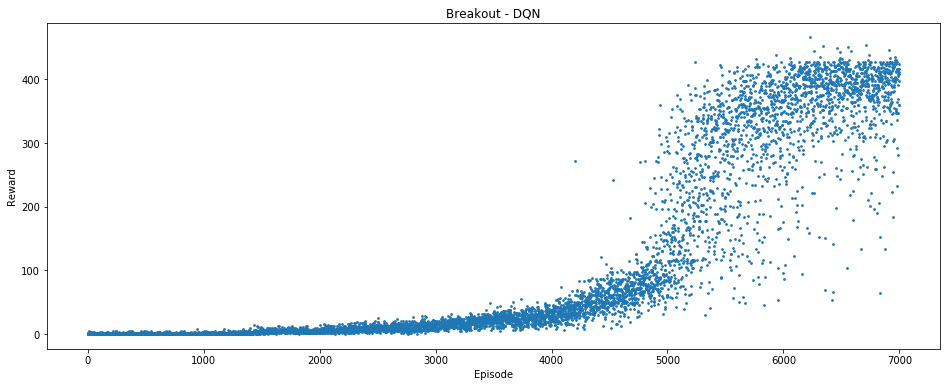

In [10]:
plt.figure(figsize=(16, 6))
plt.title('Breakout - DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(len(rewards)), rewards, s=3)

## Pong

> Pong is a two-dimensional sports game that simulates table tennis. The player controls an in-game paddle by moving it vertically across the left or right side of the screen. They can compete against another player controlling a second paddle on the opposing side. Players use the paddles to hit a ball back and forth. The goal is for each player to reach eleven points before the opponent; points are earned when one fails to return the ball to the other.

_Description from_ [Wikipedia](https://en.wikipedia.org/wiki/Pong)

![Pong](../assets/Pong_160x210.gif)

### Action space

Pong has 6 actions:

In [11]:
env = gym.make('PongDeterministic-v4')
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

Let's make our agent's life easier by using only 3 of them: `NOOP`, `RIGHT`, and `LEFT`. Similarly to Breakout, we have to preprocess actions because we skip `FIRE`:

In [12]:
class PongConverter(AtariConverter):
    def convert_action(self, a):
        if a == 0:
            # NOOP
            return a

        # RIGHT, LEFT
        return a + 1

### Training parameters

In [13]:
# Environment
env_name = 'PongDeterministic-v4'

# Brain
n_hidden = 512
n_outputs = 3
lr = 0.0001
target_update_freq = 5000

# Action Selection Policy
start_eps = 1.0
end_eps = 0.01
eps_decay = 2

# Experience Replay Memory
replay_memory_size = 1000000
replay_batch_size = 32
replay_time_steps = 4

# Agent
n_episodes = 500
gamma = 0.99
train_freq = 4

In [14]:
env_name = 'PongDeterministic-v4'

n_hidden = 512
n_outputs = 3
lr = 0.00005
target_update_freq = 5000

start_eps = 1.0
end_eps = 0.01
eps_decay = 4

replay_memory_size = 1000000
replay_batch_size = 32
replay_time_steps = 4

n_episodes = 1000
gamma = 0.99
train_freq = 4

### Learning

In [15]:
env = gym.make(env_name)
target_brain = AtariBrain(n_hidden, n_outputs, replay_batch_size, replay_time_steps)
brain = AtariBrain(n_hidden, n_outputs, replay_batch_size, replay_time_steps, 
                   lr, target_brain, target_update_freq)
acting = DecayingEpsGreedyPolicy(start_eps, end_eps, eps_decay)
replay_memory = EpisodicMemory(replay_memory_size, replay_batch_size, 
                               replay_time_steps)
converter = PongConverter()

agent = AtariAgent(n_episodes, env, brain, acting, replay_memory, 
                   gamma, converter, train_freq)

rewards, _ = agent.run()

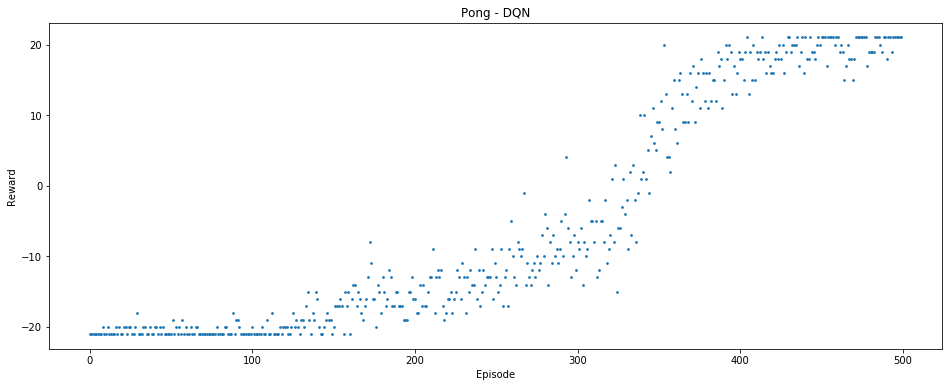

In [16]:
plt.figure(figsize=(16, 6))
plt.title('Pong - DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(len(rewards)), rewards, s=3)

## Space Invaders

> Space Invaders is a fixed shooter in which the player controls a laser cannon by moving it horizontally across the bottom of the screen and firing at descending aliens. The aim is to defeat five rows of eleven aliens—although some versions feature different numbers—that move horizontally back and forth across the screen as they advance toward the bottom of the screen. The player's laser cannon is partially protected by several stationary defense bunkers—the number also varies by version—that are gradually destroyed from the top and bottom by blasts from either the aliens or the player.

_Description from_ [Wikipedia](https://en.wikipedia.org/wiki/Space_Invaders)

![SpaceInvaders](../assets/SpaceInvaders_160x210.gif)

### Action space

Space Invaders also has 6 actions:

In [17]:
env = gym.make('SpaceInvadersDeterministic-v4')
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

But in order to speed up training, we will be using only first 4: `NOOP`, `FIRE`, `RIGHT`, and `LEFT`. No preprocessing is needed this time.

### Training parameters

In [18]:
# Environment
env_name = 'SpaceInvadersDeterministic-v4'

# Brain
n_hidden = 1024
n_outputs = 4
lr = 0.00005
target_update_freq = 10000

# Action Selection Policy
start_eps = 1.0
end_eps = 0.01
eps_decay = 2

# Experience Replay Memory
replay_memory_size = 1000000
replay_batch_size = 32
replay_time_steps = 4

# Agent
n_episodes = 10000
gamma = 0.99
train_freq = 4

### Learning

In [19]:
env = gym.make(env_name)
target_brain = AtariBrain(n_hidden, n_outputs, replay_batch_size, replay_time_steps)
brain = AtariBrain(n_hidden, n_outputs, replay_batch_size, replay_time_steps, 
                   lr, target_brain, target_update_freq)
acting = DecayingEpsGreedyPolicy(start_eps, end_eps, eps_decay)
replay_memory = EpisodicMemory(replay_memory_size, replay_batch_size, 
                               replay_time_steps)
converter = AtariConverter()

agent = AtariAgent(n_episodes, env, brain, acting, replay_memory, 
                   gamma, converter, train_freq)

rewards, _ = agent.run()

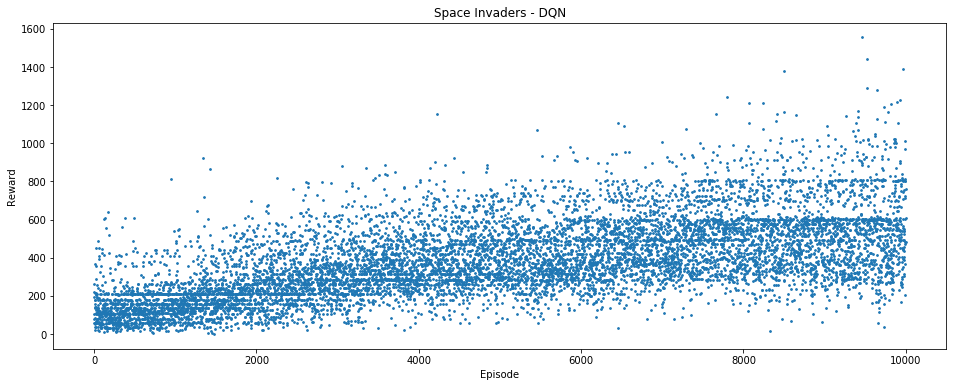

In [20]:
plt.figure(figsize=(16, 6))
plt.title('Space Invaders - DQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.scatter(range(len(rewards)), rewards, s=3)

***

Brain image source: momentousinstitute.org